# Declaration of Originality

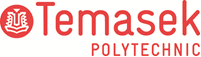

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Nathan
* Tutorial Group                : 
* Tutor						    :  
* Submission Date               : 


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

In [ ]:
## Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

## Import Linear Regression model for model 1
from sklearn.linear_model import LinearRegression

## Import Random Forest Regressor for model 2
from sklearn.ensemble import RandomForestRegressor

## Import Gradient Boosting Regressor for model 3
from sklearn.ensemble import GradientBoostingRegressor

## Import Dummy Regressor for baseline model
from sklearn.dummy import DummyRegressor

# Import RandomizedSearchCV and TimeSeriesSplit for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib


# 1. Business Understanding
Goal: ?

# 2. Data Understanding

## 2.1 Load dataset

In [65]:
## Read *.csv file into pandas DataFrame
FILE_PATH = r"Energy Production Dataset.csv"  # <-- change if needed
df = pd.read_csv(FILE_PATH)
df

# Parse date and sort (important for time-based split)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Date", "Start_Hour"]).reset_index(drop=True)

# Helpful feature engineering
df["Is_Weekend"] = df["Day_Name"].isin(["Saturday", "Sunday"]).astype(int)

month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}
df["Month_Num"] = df["Month_Name"].map(month_map)

# Add "Year" column for feature engineering
df["Year"] = df["Date"].dt.year

# Cyclical encoding for Start_Hour (0–23)
df["Hour_sin"] = np.sin(2 * np.pi * df["Start_Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Start_Hour"] / 24)

# Cyclical encoding for Day_of_Year (1–365/366)
df["Doy_sin"] = np.sin(2 * np.pi * df["Day_of_Year"] / 365)
df["Doy_cos"] = np.cos(2 * np.pi * df["Day_of_Year"] / 365)


print(df.head())
print(df.info())

        Date  Start_Hour  End_Hour Source  Day_of_Year   Day_Name Month_Name  \
0 2020-01-01           0         1   Wind            1  Wednesday    January   
1 2020-01-01           1         2   Wind            1  Wednesday    January   
2 2020-01-01           2         3   Wind            1  Wednesday    January   
3 2020-01-01           3         4   Wind            1  Wednesday    January   
4 2020-01-01           4         5   Wind            1  Wednesday    January   

   Season  Production  Is_Weekend  Month_Num  Year  Hour_sin  Hour_cos  \
0  Winter        3542           0          1  2020  0.000000  1.000000   
1  Winter        2932           0          1  2020  0.258819  0.965926   
2  Winter        2725           0          1  2020  0.500000  0.866025   
3  Winter        2761           0          1  2020  0.707107  0.707107   
4  Winter        2708           0          1  2020  0.866025  0.500000   

    Doy_sin   Doy_cos  
0  0.017213  0.999852  
1  0.017213  0.999852  
2 

## 2.2 Summary Statistics

In [66]:
## Understand the type of variable for each column
print("\nMissing values:\n", df.isna().sum())
print("\nTarget summary (Production):\n", df["Production"].describe())



Missing values:
 Date           0
Start_Hour     0
End_Hour       0
Source         0
Day_of_Year    0
Day_Name       0
Month_Name     0
Season         0
Production     0
Is_Weekend     0
Month_Num      0
Year           0
Hour_sin       0
Hour_cos       0
Doy_sin        0
Doy_cos        0
dtype: int64

Target summary (Production):
 count    51864.000000
mean      6215.069933
std       3978.364965
min         58.000000
25%       3111.000000
50%       5372.000000
75%       8501.000000
max      23446.000000
Name: Production, dtype: float64


In [ ]:
## Check for missing data


In [ ]:
## Describe data distribution


## 2.3 Data Visualization

### 2.3.1 Understanding distribution of data

### 2.3.1.1 Understanding distribution of target

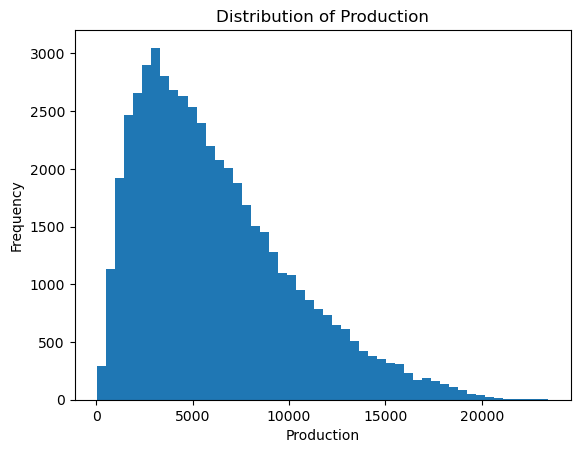

In [45]:
## Understanding distribution of target
# --- Target distribution: Production ---
plt.figure()
plt.hist(df["Production"], bins=50)
plt.title("Distribution of Production")
plt.xlabel("Production")
plt.ylabel("Frequency")
plt.show()


### 2.3.1.2 Understanding distribution of features

<Figure size 640x480 with 0 Axes>

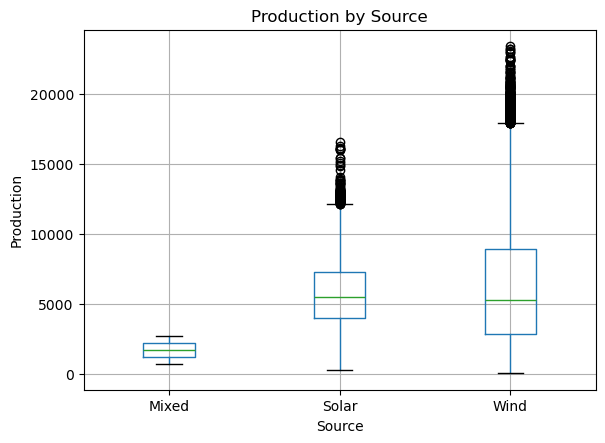

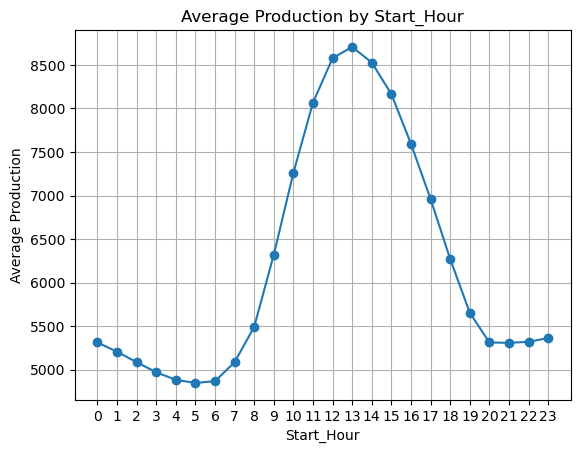

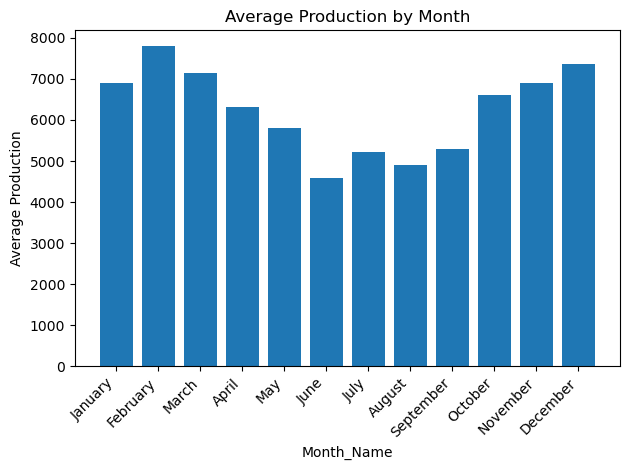

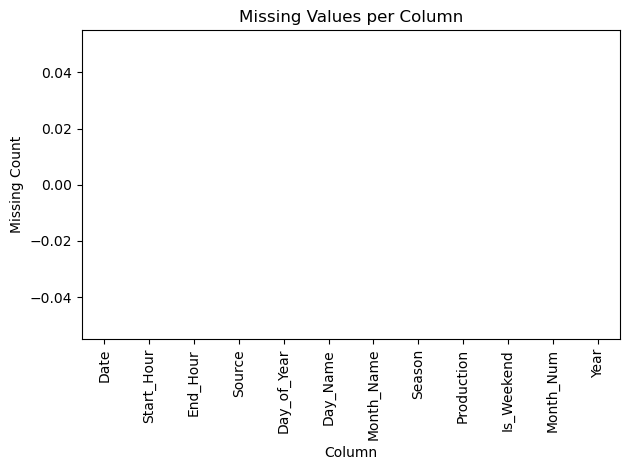

In [46]:
## Understanding distribution of features
# --- Production by Source (boxplot) ---
plt.figure()
df.boxplot(column="Production", by="Source")
plt.title("Production by Source")
plt.suptitle("")  # removes automatic pandas subtitle
plt.xlabel("Source")
plt.ylabel("Production")
plt.show()

# --- Production by Start_Hour (average trend) ---
hourly_mean = df.groupby("Start_Hour")["Production"].mean()
plt.figure()
plt.plot(hourly_mean.index, hourly_mean.values, marker="o")
plt.title("Average Production by Start_Hour")
plt.xlabel("Start_Hour")
plt.ylabel("Average Production")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# --- Production by Month_Name (average) ---
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

monthly_mean = df.groupby("Month_Name")["Production"].mean().reindex(month_order)

plt.figure()
plt.bar(monthly_mean.index, monthly_mean.values)
plt.title("Average Production by Month")
plt.xlabel("Month_Name")
plt.ylabel("Average Production")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Optional: check missing values visually ---
plt.figure()
(df.isna().sum().sort_values(ascending=False)).plot(kind="bar")
plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Missing Count")
plt.tight_layout()
plt.show()

## Data analysis, documentation of trends

### 2.3.2 Understanding relationship between variables

In [ ]:
## Understanding relationship between variables


# 3. Data Preparation

## 3.1 Data Cleaning

In [67]:
target_col = "Production"

feature_cols = [
    "Hour_sin", "Hour_cos",
    "Doy_sin", "Doy_cos",
    "Year",       
    "Source",
    "Day_Name",
    "Month_Name",
    "Season"
]

# Time-based split
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df[target_col].copy()

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (41491, 9) Test size: (10373, 9)


## 3.2 Train-Test Split

In [68]:
# Time-based Train-Test Split (first 80% train, last 20% test)
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

print("Train size:", train_df.shape, "Test size:", test_df.shape)

Train size: (41491, 16) Test size: (10373, 16)


# 4. Modelling

### 4.2 Train Model

In [69]:
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]   # keep for later evaluation
y_test = test_df[target_col]     # keep for later evaluation

numeric_features = ["Hour_sin", "Hour_cos", "Doy_sin", "Doy_cos", "Year"]
categorical_features = ["Source", "Month_Name", "Season", "Day_Name"]

# Preprocessing: Linear needs scaling; Tree doesn't
preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

# Define pipelines for both models
pipe_linr = Pipeline(steps=[
    ("preprocess", preprocess_linear),
    ("model", LinearRegression())
])

pipe_gb = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", GradientBoostingRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3
    ))
])

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

pipe_dummy = Pipeline(steps=[
    ("preprocess", preprocess_tree),   # one-hot encodes categories
    ("model", DummyRegressor(strategy="mean"))
])


In [70]:
# Train models

pipe_linr.fit(X_train, y_train)
pipe_gb.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_dummy.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 5. Model Evaluation

In [71]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# ---- Predict ----
pred_linr = pipe_linr.predict(X_test)
pred_gb = pipe_gb.predict(X_test)
pred_rf = pipe_rf.predict(X_test)
pred_dummy = pipe_dummy.predict(X_test)

# ---- Metrics ----
results = []
m1 = regression_metrics(y_test, pred_linr)
m1["Model"] = "LinearRegression (Baseline)"
results.append(m1)

m2 = regression_metrics(y_test, pred_rf)
m2["Model"] = "RandomForestRegressor"
results.append(m2)

m3 = regression_metrics(y_test, pred_gb)
m3["Model"] = "GradientBoostingRegressor"
results.append(m3)

m0 = regression_metrics(y_test, pred_dummy)
m0["Model"] = "DummyRegressor (Mean Baseline)"
results.append(m0)

results_df = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
results_df

,MAE,MSE,RMSE,R2
Model,,,,
LinearRegression (Baseline),3368.403697,1.717562e+07,4144.348467,0.109354
GradientBoostingRegressor,3207.226112,1.742589e+07,4174.432898,0.096376
RandomForestRegressor,3412.049921,2.045485e+07,4522.704133,-0.060692
DummyRegressor (Mean Baseline),3496.065172,2.055024e+07,4533.237634,-0.065638


In [ ]:
## New data
new_data = pd.DataFrame([{
    "Start_Hour": 14,
    "Day_of_Year": 120,
    "Source": "Solar",
    
    "Day_Name": "Monday",
    "Month_Name": "April",
    "Season": "Spring"
}])

## Predict
pred = pipe_linr.predict(new_data)[0]
print("\nPrediction for new data:", pred)

## 6. Hyperparameter tuning

In [ ]:
pipe_gb_base = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", GradientBoostingRegressor(random_state=42))
])

# IMPORTANT: Project requirement says no more than 3 values per hyperparameter.
# We'll tune 3 hyperparameters with exactly 3 values each.
param_dist_gb = {
    "model__n_estimators": [150, 300, 500],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4]
}

# Time-series friendly cross validation (still "cv=5" like slides, but no shuffling/leakage)
tscv = TimeSeriesSplit(n_splits=5)

rs_gb = RandomizedSearchCV(
    estimator=pipe_gb_base,
    param_distributions=param_dist_gb,
    cv=tscv,  # 5 folds, time-aware
    scoring="neg_mean_squared_error",  # same as slides
    n_iter=10,  # same as slides
    n_jobs=-1,  # same as slides
    random_state=42,
    verbose=1
)

rs_gb.fit(X_train, y_train)

print("Best parameters:", rs_gb.best_params_)
best_cv_rmse = np.sqrt(-rs_gb.best_score_)
print("Best CV RMSE:", best_cv_rmse)

## 7. Model evaluation pt2

## 8. Save model (For Streamlit)


In [ ]:
# TODO: Use this to save the best model later
best_model_name = results_df.index[0]  # lowest RMSE
best_model = pipe_linr if "LinearRegression" in best_model_name else pipe_dtr

joblib.dump(best_model, "best_energy_model.pkl")
print("Saved:", best_model_name, "-> best_energy_model.pkl")